In [1]:
import json
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline

## 1. Load Particle Data from JSON Files
We load all JSON files, parse the filename to extract the distribution type and sample number, and compute the geometric mean of each particle's dimensions.
We also compute the 10th, 50th, and 90th percentiles (d10, d50, d90) for each sample.


In [4]:
json_files = glob.glob('./dataset/particles/*.json')

# Data structure to store extracted information
data_list = []

for file in json_files:
    filename = os.path.basename(file)  # e.g. "particles_truncnorm_0001.json"
    parts = filename.split('_')
    if len(parts) < 3:
        continue  # skip files that don't match the expected pattern
    dist = parts[1]
    sample_num = int(parts[2].split('.')[0])
    
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Compute the geometric mean of (length, width, thickness) for each particle
    sizes = []
    for particle in data['particles']:
        l = particle['length']
        w = particle['width']
        t = particle['thickness']
        gm = (l * w * t) ** (1/3)
        sizes.append(gm)
        
    data_list.append({
        'file': file,
        'distribution': dist,
        'sample_num': sample_num,
        'size_mean': data.get('size_mean'),
        'size_sigma': data.get('size_sigma'),
        'aspect_variation': data.get('aspect_variation'),
        'num_particles': data.get('samplesize'),
        'sizes': sizes,
        'd10': np.percentile(sizes, 10),
        'd50': np.percentile(sizes, 50),
        'd90': np.percentile(sizes, 90)
    })


In [5]:

# Convert list to DataFrame for easier analysis
df = pd.DataFrame(data_list)
df.sort_values(by=['distribution', 'sample_num'], inplace=True)
df.head()

,file,distribution,sample_num,size_mean,size_sigma,aspect_variation,num_particles,sizes,d10,d50,d90
12,./dataset/particles/particles_beta_0001.json,beta,1,2.209278,3.404992,0.534642,165,"[1.8185553083353514, 0.4021168707768835, 1.583...",0.423903,1.671276,5.651638
23,./dataset/particles/particles_beta_0002.json,beta,2,9.604308,3.796527,0.039586,121,"[12.214829506381415, 15.989831613266118, 14.96...",4.273063,9.001634,14.040348
16,./dataset/particles/particles_beta_0003.json,beta,3,3.141682,2.222494,0.258969,254,"[1.5329876702150558, 2.7274058903951155, 8.859...",0.528595,1.892136,7.081995
0,./dataset/particles/particles_beta_0004.json,beta,4,3.124433,0.502348,0.277241,139,"[1.4922612774869224, 5.960427571502329, 0.7317...",0.551488,2.278795,6.385841
13,./dataset/particles/particles_beta_0005.json,beta,5,6.606115,2.992969,0.556635,289,"[3.5006713838797903, 11.457966715102854, 3.338...",1.939457,6.497380,12.247290


## 2. Distribution Plots of Particle Sizes
For each distribution type, we combine sizes from all samples and plot a histogram (with KDE) to visualize the spread.


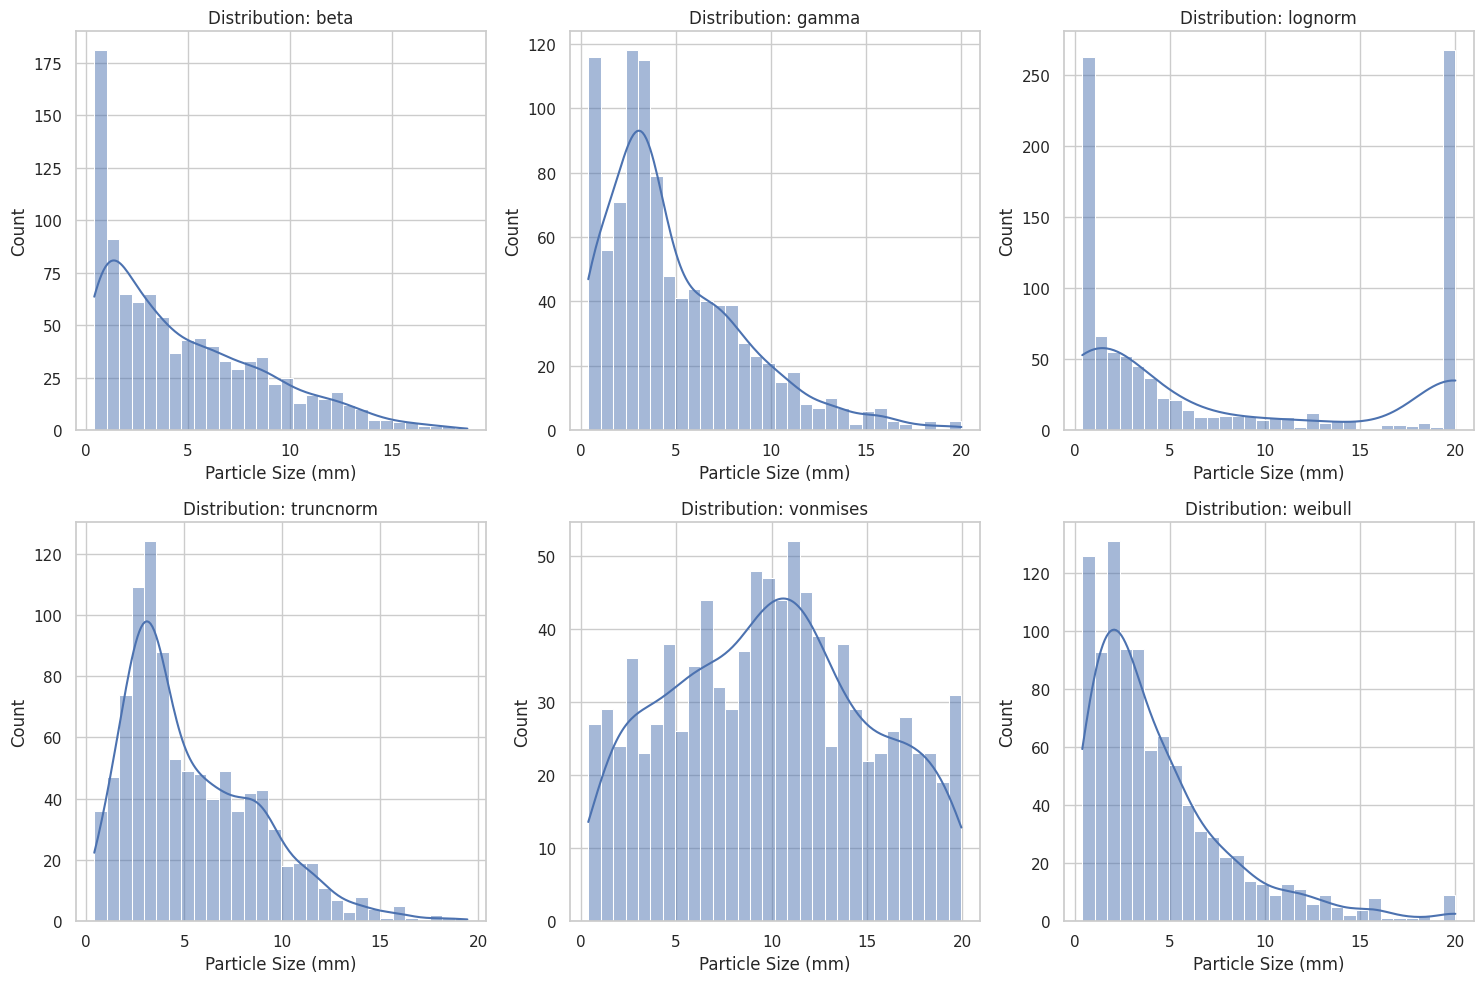

In [6]:
# Get unique distribution types
dists = df['distribution'].unique()

plt.figure(figsize=(15, 10))
for i, dist in enumerate(dists):
    plt.subplot(2, 3, i+1)
    subset = df[df['distribution'] == dist]
    # Combine all sizes for the current distribution
    all_sizes = np.concatenate(subset['sizes'].values)
    sns.histplot(all_sizes, bins=30, kde=True)
    plt.title(f"Distribution: {dist}")
    plt.xlabel("Particle Size (mm)")
plt.tight_layout()
plt.show()

## 3. Comparison of Key Percentiles (d10, d50, d90)
Here we compare the d10, d50, and d90 values (which indicate the particle sizes at 10%, 50%, and 90% cumulative volume) across different distributions.
We'll use a boxplot to show the spread of these values for each distribution.


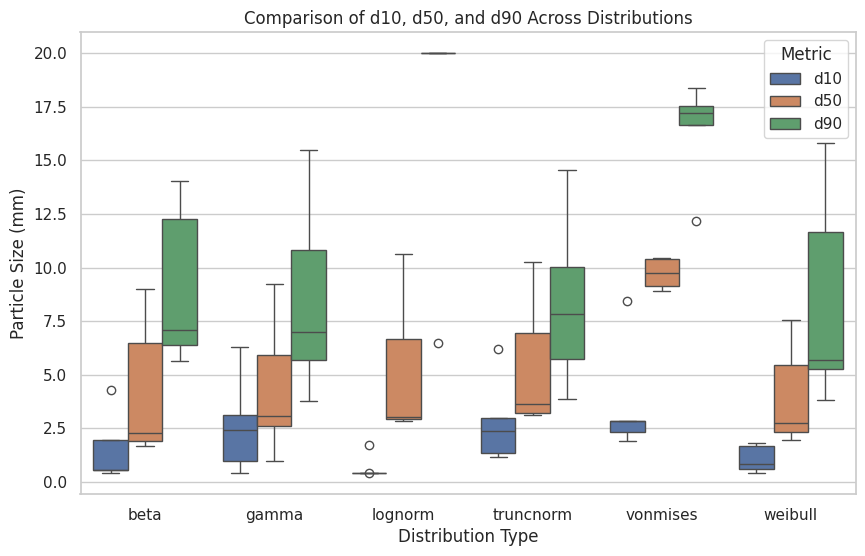

In [7]:
# Prepare a DataFrame with d10, d50, and d90 for each sample
stats_df = df[['distribution', 'sample_num', 'd10', 'd50', 'd90']]
melted = pd.melt(stats_df, id_vars=['distribution', 'sample_num'], value_vars=['d10','d50','d90'],
                 var_name='Metric', value_name='Particle Size (mm)')

plt.figure(figsize=(10, 6))
sns.boxplot(x='distribution', y='Particle Size (mm)', hue='Metric', data=melted)
plt.title("Comparison of d10, d50, and d90 Across Distributions")
plt.xlabel("Distribution Type")
plt.ylabel("Particle Size (mm)")
plt.legend(title="Metric")
plt.show()

## 4. Rendered Image Comparison
Next, we display one rendered image (the first sample, sample 0001) for each distribution type to visually compare the outputs.

_Note:_ Make sure the render images exist in `./dataset4/renders` and follow the naming convention `render_{distribution}_{sample_num:04d}.png`.


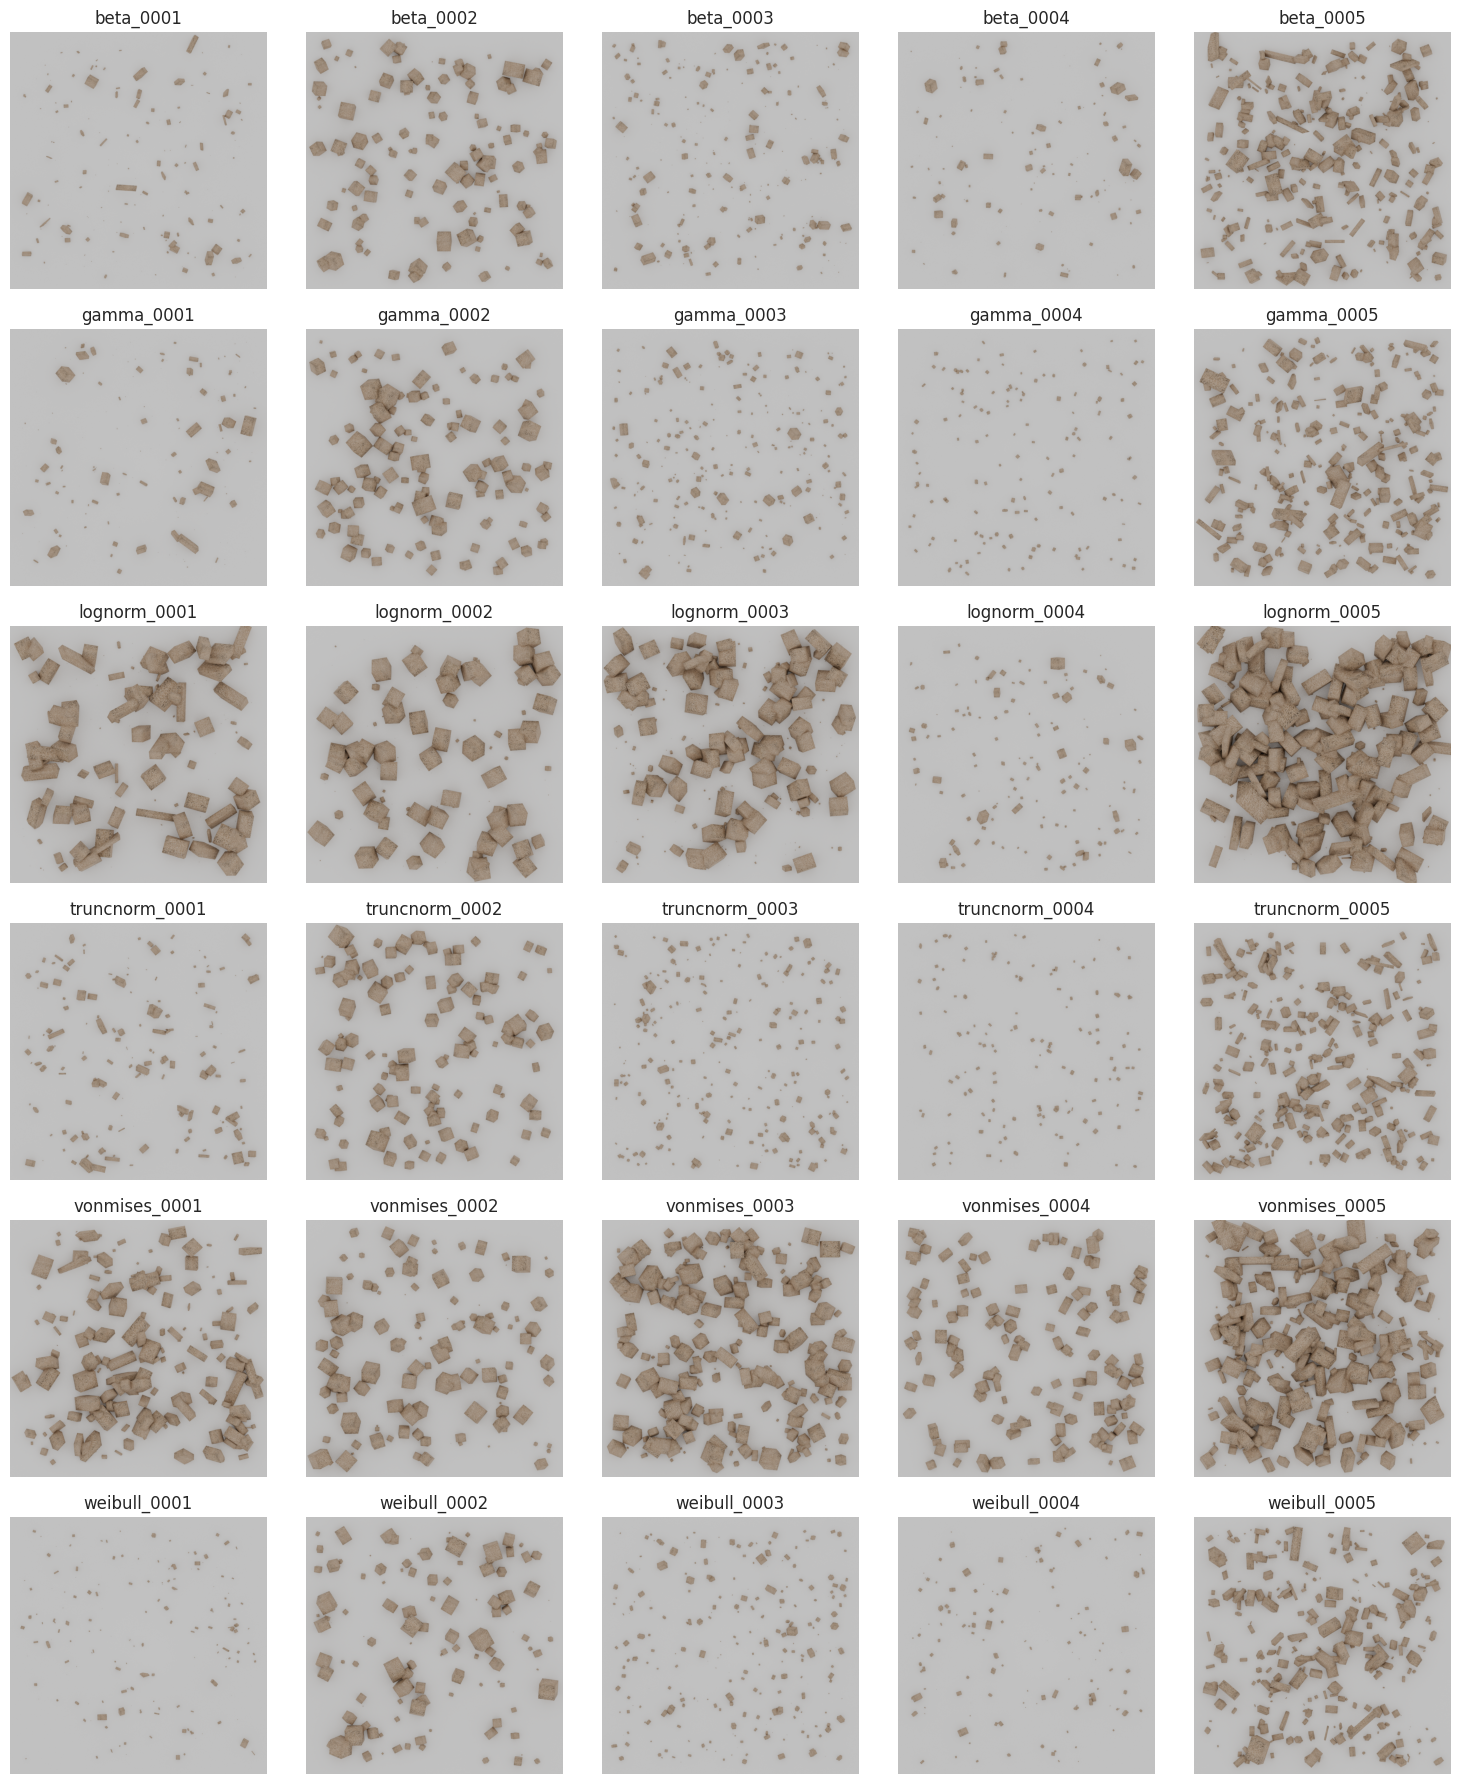

In [22]:
# Define the directory where rendered images are stored
render_dir = "dataset/renders"

# Get unique distribution types
dists = df['distribution'].unique()
rows, cols = 6, 5  # 6 distributions, 5 samples each

fig, axes = plt.subplots(rows, cols, figsize=(15, 18))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop over distributions and sample numbers
n = 0
for dist in dists:
    for j in range(1, 6):  # Sample numbers from 0001 to 0005
        image_path = os.path.join(render_dir, f"render_{dist}_000{j}.png")

        if os.path.exists(image_path):
            img = plt.imread(image_path)
            axes[n].imshow(img)
            axes[n].set_title(f"{dist}_000{j}")
            axes[n].axis("off")  # Hide axes for a cleaner display
        else:
            axes[n].set_title(f"Missing: {dist}_000{j}")
            axes[n].axis("off")
        n += 1

plt.tight_layout()
plt.show()


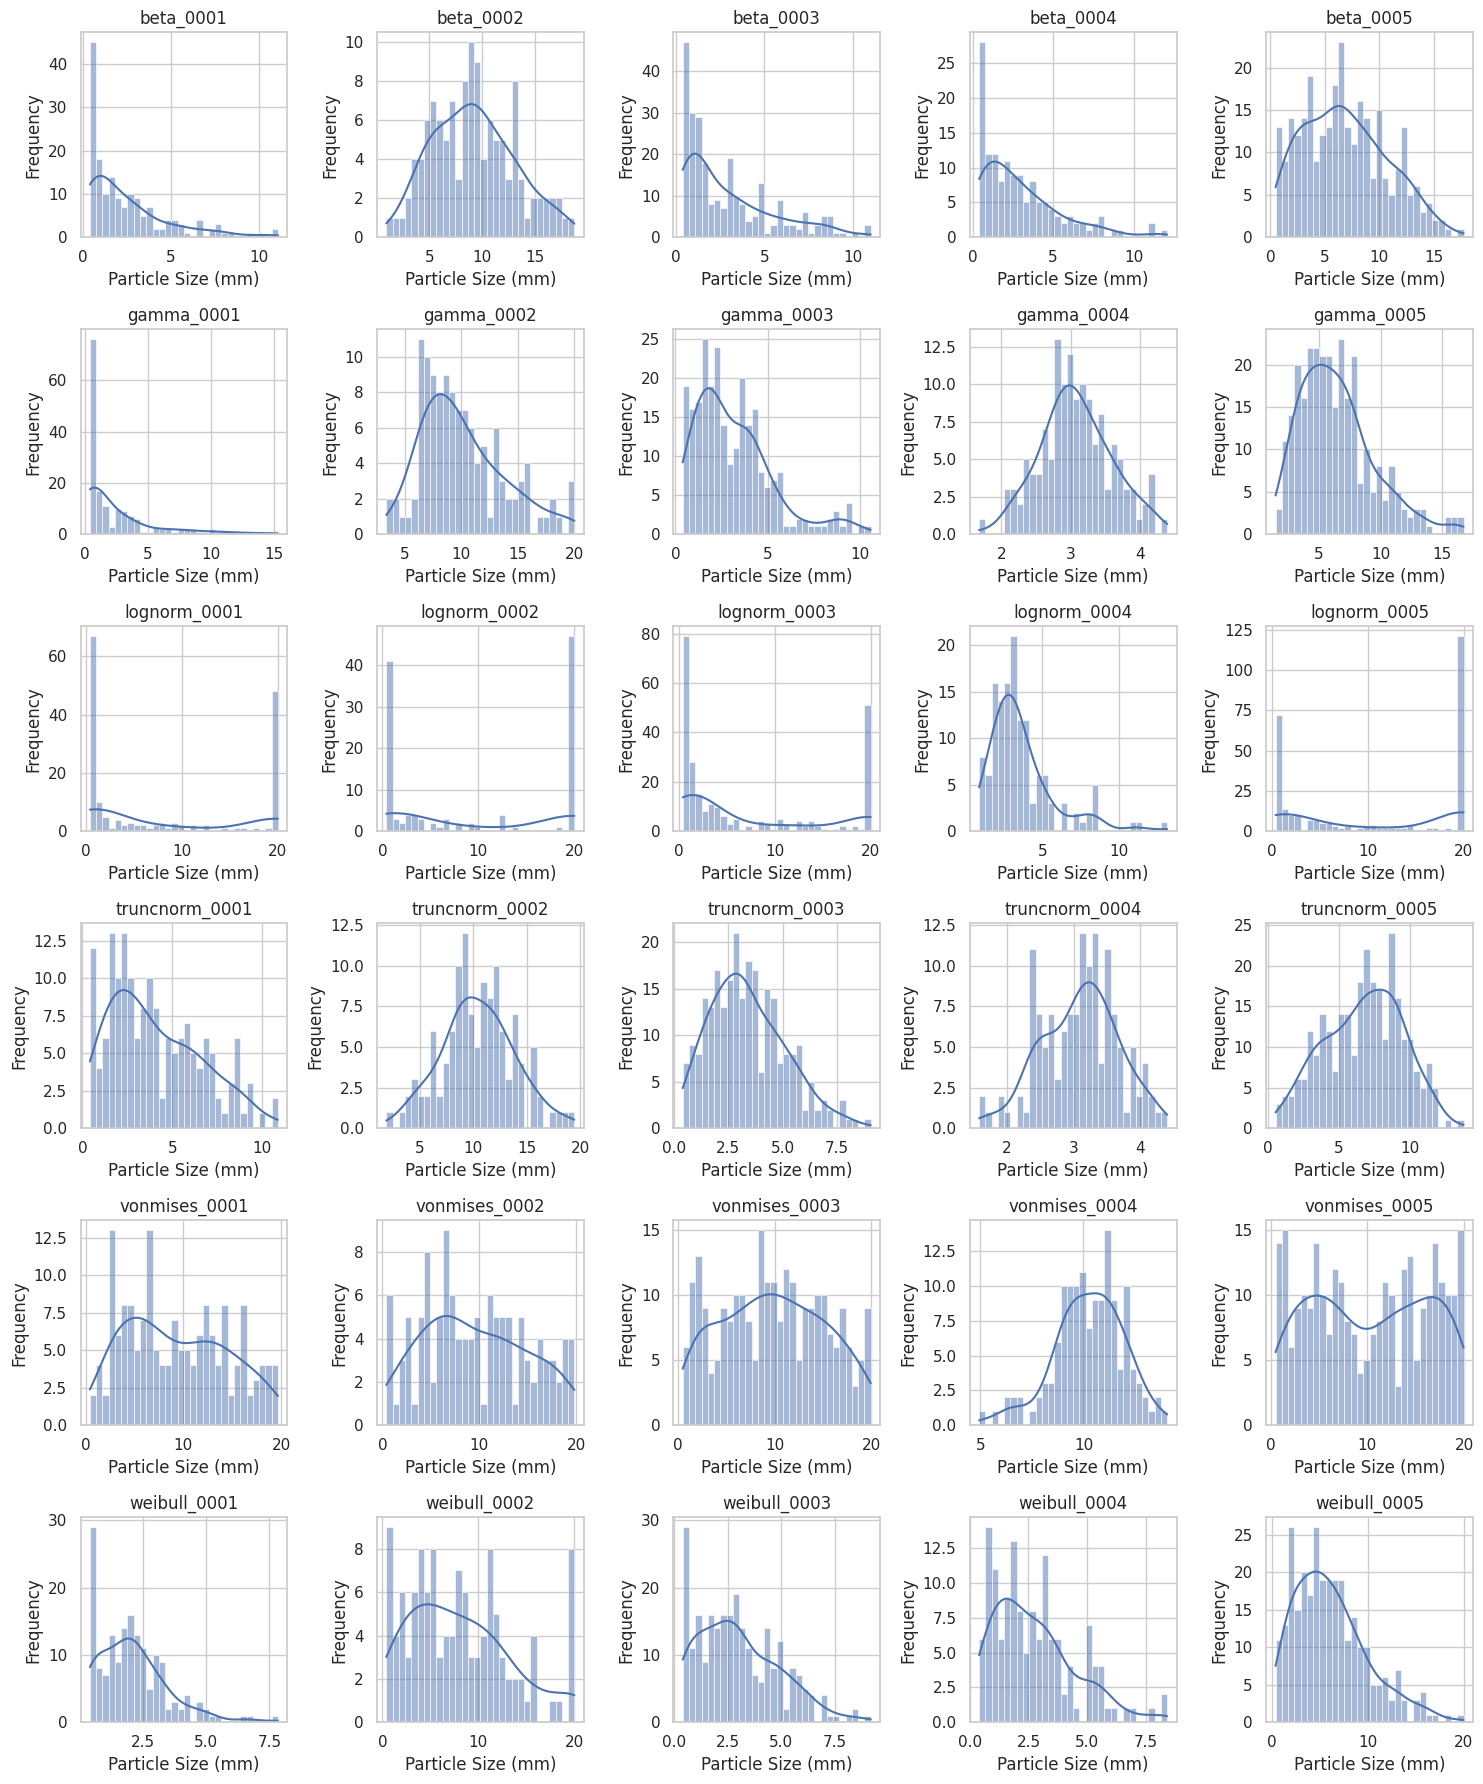

In [23]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 18))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop over distributions and sample numbers
n = 0
for dist in dists:
    for j in range(1, 6):  # Sample numbers from 0001 to 0005
        subset = df[(df['distribution'] == dist) & (df['sample_num'] == j)]
        
        if not subset.empty:
            all_sizes = np.concatenate(subset['sizes'].values)
            sns.histplot(all_sizes, bins=30, kde=True, ax=axes[n])
        
        axes[n].set_title(f"{dist}_000{j}")
        axes[n].set_xlabel("Particle Size (mm)")
        axes[n].set_ylabel("Frequency")
        
        n += 1

plt.tight_layout()
plt.show()


## 5. Additional Statistical Analysis
We can also compute summary statistics for the d50 values across distributions. For example, we compute the mean, median, and standard deviation of d50.
Additionally, we can plot a scatter plot comparing d10 and d90 values to see the spread for each sample.


Summary statistics for d50 (median particle size):
  distribution      mean    median       std
0         beta  4.268244  2.278795  3.306133
1        gamma  4.354998  3.050831  3.258411
2      lognorm  5.233255  3.042994  3.425358
3    truncnorm  5.436091  3.637540  3.117679
4     vonmises  9.732570  9.745991  0.701535
5      weibull  4.000759  2.745255  2.416991


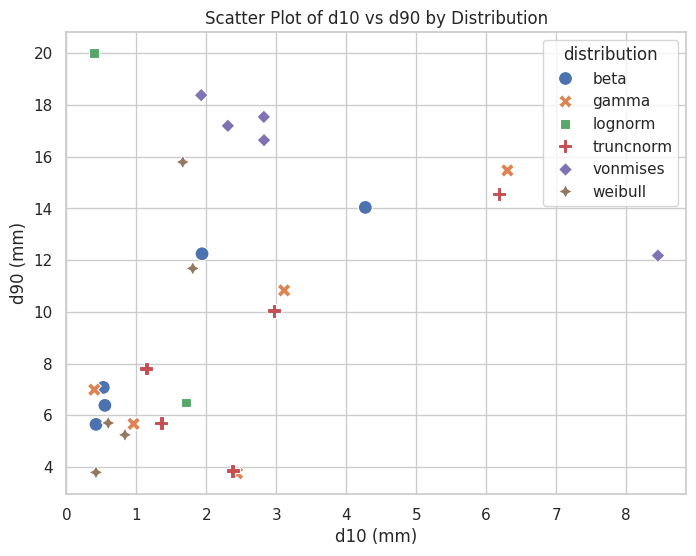

In [9]:
# Summary statistics for d50 by distribution
summary = df.groupby('distribution')['d50'].agg(['mean', 'median', 'std']).reset_index()
print("Summary statistics for d50 (median particle size):")
print(summary)

# Scatter plot of d10 vs d90 for each sample, colored by distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x='d10', y='d90', hue='distribution', style='distribution', data=df, s=100)
plt.title("Scatter Plot of d10 vs d90 by Distribution")
plt.xlabel("d10 (mm)")
plt.ylabel("d90 (mm)")
plt.show()

## 6. Conclusions & Next Steps
From the above plots and statistics, you can start to compare: 
 - **Visual Rendering:** Do some distributions produce noticeably different visual outcomes?
 - **Size Distributions:** How do the histograms and KDE curves compare across distributions?
 - **Percentile Metrics:** How do d10, d50, and d90 vary? Which distributions produce more consistent or more varied results?
 
 You might further refine this analysis by fitting candidate theoretical distributions to the measured sizes and using goodness-of-fit tests (e.g., KS test) to assess which distribution best models your data.
 
 Experiment and extend this notebook as needed to answer your research questions!
